In [1]:
import numpy as np
import matplotlib.pyplot as plt
from celmech.secular import SecularSystemSimulation,LaplaceLagrangeSystem
import rebound as rb
from celmech.nbody_simulation_utilities import set_timestep, align_simulation, get_simarchive_integration_results

In [2]:
# Define a method to integrate a secular simulation and return results near a series of user-specified times
def run_secular_sim(sec_sim,times, corrector=False):
    N = len(times)
    eccN,incN,pomegaN,OmegaN = np.zeros((4,sec_sim.state.N - 1,N))
    Eerr = np.zeros(N)
    AMDerr = np.zeros(N)
    timesDone = np.zeros(N)
    E0 = sec_sim.calculate_energy()
    AMD0 = sec_sim.calculate_AMD()
    for i,time in enumerate(times):
        sec_sim.integrate(time, corrector=corrector)
        timesDone[i] = sec_sim.t
        E = sec_sim.calculate_energy()
        AMD = sec_sim.calculate_AMD()
        Eerr[i] = np.abs((E-E0)/E0)
        AMDerr[i] = np.abs((AMD-AMD0)/AMD0)
        for j,p in enumerate(sec_sim.state.particles[1:]):
            eccN[j,i] = p.e
            incN[j,i] = p.inc
            pomegaN[j,i] = p.pomega
            OmegaN[j,i] = p.Omega
    return timesDone, Eerr, AMDerr, eccN, incN,pomegaN,OmegaN

The example system is generated from a random draw of the TTV fit posteriors for Kepler-23. 
The planets have been given some (unrealistically) large mutual inclinations in order make the effects of non-linear secular terms more dramatic.

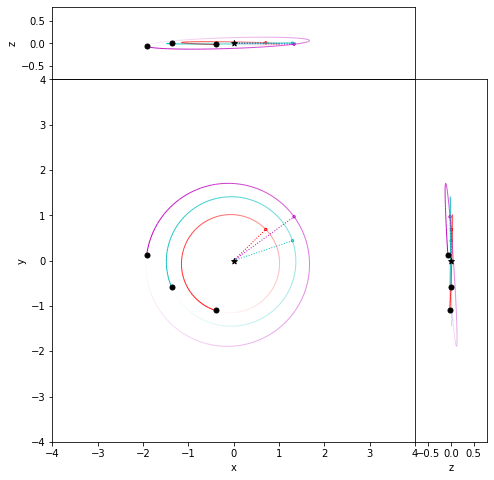

In [3]:
# Get initial conditions
sim = rb.Simulation('./Kepler-23_Nonlinear_Secular_Example.bin')
ps= sim.particles
# Show orbit plot
rb.OrbitPlot(sim,xlim=(-4,4),ylim=(-4,4),slices=0.2,color=True,periastron=True);

### $N$-body simulation

In [4]:
sa_file = './Kepler-23_Nonlinear_Secular_Example.sa'
try:
    sa = rb.SimulationArchive(sa_file)
except:
    sim.automateSimulationArchive(sa_file,interval=500 * ps[1].P)
    sim.integrator = 'whfast'
    sim.ri_whfast.safe_mode=0
    set_timestep(sim,1/25.)
    %time sim.integrate(1e6 * ps[1].P)
    sa = rb.SimulationArchive(sa_file)

In [5]:
nbody_results = get_simarchive_integration_results(sa)

### Comparison with Laplace-Lagrange theory

In [6]:
llsys = LaplaceLagrangeSystem.from_Simulation(sa[0])

ll_results = llsys.secular_solution(nbody_results['time'])

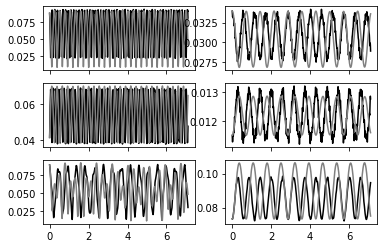

In [7]:
fig,ax = plt.subplots(3,2,sharex=True)
for i in range(3):
    ax[i,0].plot(nbody_results['time']/1e6,nbody_results['e'][i],'k')
    ax[i,0].plot(ll_results['time']/1e6,ll_results['e'][i],'gray')
    
    ax[i,1].plot(nbody_results['time']/1e6,nbody_results['inc'][i],'k')
    ax[i,1].plot(ll_results['time']/1e6,ll_results['inc'][i],'gray')

### Comparison with Laplace-Lagrange theory with resonance correction

In [8]:
sim = sa[0]
# Find nearest first- and second-order MMRs based on orbital periods

periods = np.array([p.P for p in sim.particles[1:]])
second_order_res=np.array(np.round(2 + 2/(periods[1:]/periods[:-1]-1)),dtype=np.int64)

res_to_include = {(i+1,i+2):[(j//2,1) if j%2==0 else (j,2)] for i,j in enumerate(second_order_res)}
print(res_to_include)
fo_res_to_include = {(i+1,i+2):j//2 for i,j in enumerate(second_order_res) if j%2==0 }


{(1, 2): [(3, 1)], (2, 3): [(7, 2)]}


In [9]:
llsys.add_first_order_resonance_terms(fo_res_to_include)
ll_results_res = llsys.secular_solution(nbody_results['time'])

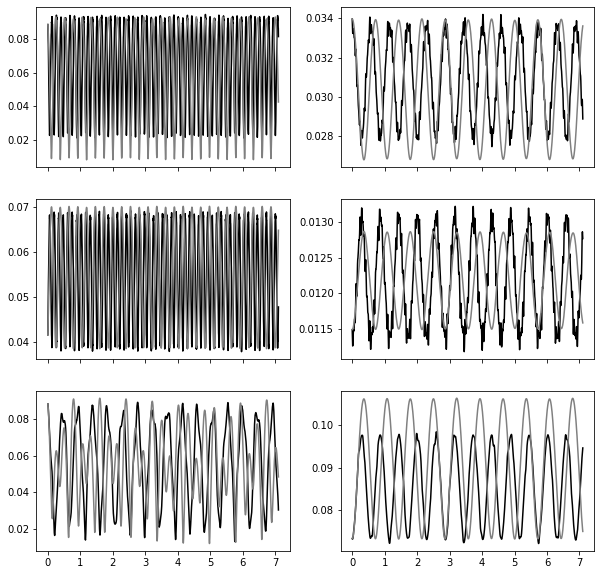

In [10]:
fig,ax = plt.subplots(3,2,sharex=True,figsize=(10,10))
for i in range(3):
    ax[i,0].plot(nbody_results['time']/1e6,nbody_results['e'][i],'k')
    ax[i,0].plot(ll_results_res['time']/1e6,ll_results['e'][i],'gray')
    
    ax[i,1].plot(nbody_results['time']/1e6,nbody_results['inc'][i],'k')
    ax[i,1].plot(ll_results_res['time']/1e6,ll_results['inc'][i],'gray')

### Non-linear secular simulation including corrections for resonances

In [11]:
sec_sim = SecularSystemSimulation.from_Simulation(
    sa[0],
    dtFraction=1/30,
    max_order=4,
    resonances_to_include=res_to_include,
    NsubB=2,
    DFOp_kwargs={'rtol':1e-10,'rkmethod':'ImplicitMidpoint'}
)

In [12]:
Tsec = llsys.Tsec
%time timesDone, Eerr, AMDerr, eccN, incN,pomegaN,OmegaN = run_secular_sim(sec_sim,np.linspace(0,600*Tsec,8*512))

CPU times: user 1min 14s, sys: 413 ms, total: 1min 14s
Wall time: 1min 15s


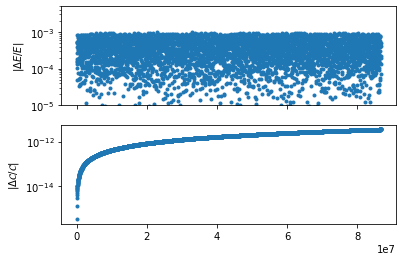

In [13]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(timesDone,Eerr,'.')
ax[1].plot(timesDone,AMDerr,'.')
ax[0].set_ylim(1e-5,0.5e-2)
ax[0].set_ylabel(r"$|\Delta E/E|$")
ax[1].set_ylabel(r"$|\Delta {\cal C}/{\cal C}|$")
for a in ax:
    a.set_yscale('log')
# ax[1].axhline(1e-10,color='k',ls='--')    
# ax[0].set_ylim(ymin=1e-9);
# ax[1].set_ylim(ymin=1e-13);

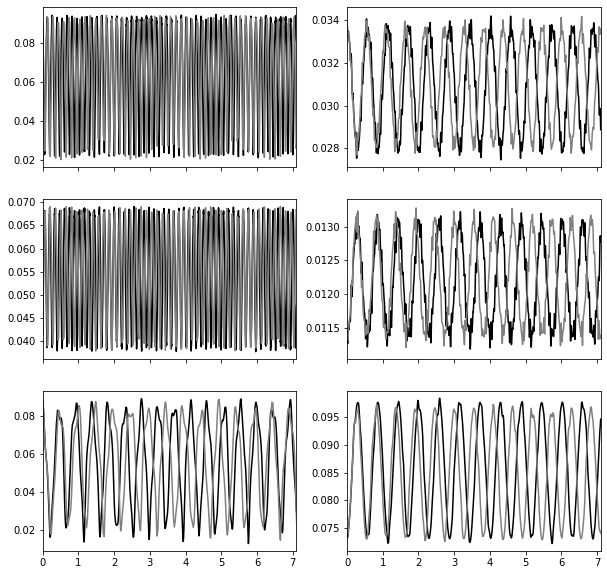

In [14]:
fig,ax = plt.subplots(3,2,sharex=True,figsize=(10,10))
for i in range(3):
    ax[i,0].plot(nbody_results['time']/1e6,nbody_results['e'][i],'k')
    ax[i,0].plot(timesDone/1e6,eccN[i],'gray')
    
    ax[i,1].plot(nbody_results['time']/1e6,nbody_results['inc'][i],'k')
    ax[i,1].plot(timesDone/1e6,incN[i],'gray')
    
for a in ax:
    a[0].set_xlim(0, nbody_results['time'][-1]/1e6)
    a[1].set_xlim(0, nbody_results['time'][-1]/1e6)

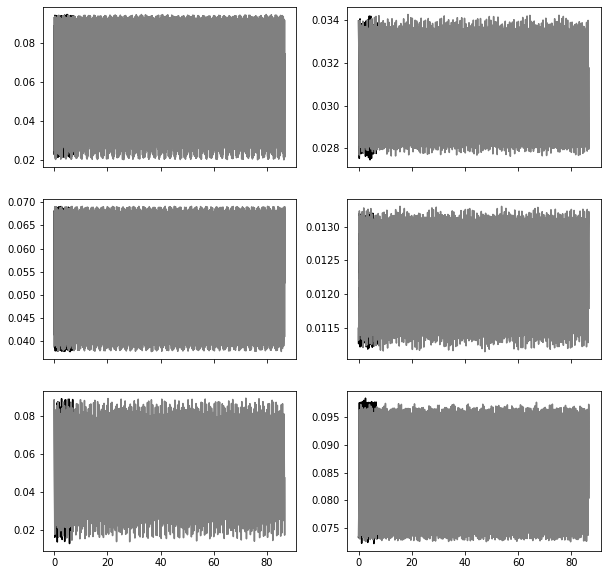

In [15]:
fig,ax = plt.subplots(3,2,sharex=True,figsize=(10,10))
for i in range(3):
    ax[i,0].plot(nbody_results['time']/1e6,nbody_results['e'][i],'k')
    ax[i,0].plot(timesDone/1e6,eccN[i],'gray')
    
    ax[i,1].plot(nbody_results['time']/1e6,nbody_results['inc'][i],'k')
    ax[i,1].plot(timesDone/1e6,incN[i],'gray')
    

### Examine secular mode decomposition of simulation results

In [16]:
from celmech.miscellaneous import frequency_modified_fourier_transform

In [17]:
zN = eccN * np.exp(1j * pomegaN)
zetaN = np.sin(incN/2) * np.exp(1j * OmegaN)

In [19]:
Nsample=len(timesDone)//2
print("Eccentricity mode decomposition")
for i in range(3):
    fFirst = frequency_modified_fourier_transform(timesDone[:Nsample],zN[i][:Nsample],3)
    fLast = frequency_modified_fourier_transform(timesDone[:Nsample],zN[i][Nsample:],3)
    fFirst_arr = np.array(list(fFirst.keys()))
    fLast_arr = np.array(list(fLast.keys()))
    dfs = 0.5 * np.abs(fFirst_arr - fLast_arr) / (fFirst_arr + fLast_arr) 
    for f,df in zip(fFirst,dfs):
        print("{} freq: {:.4g}, amp: {:.4g}, df: {:.4g}".format(i,f,np.abs(fFirst[f]),df))
    print("")

    
    

Eccentricity mode decomposition
0 freq: 1.389e-06, amp: 0.05747, df: 2.999e-06
0 freq: 3.823e-05, amp: 0.03626, df: 6.88e-07
0 freq: -6.491e-05, amp: 0.001252, df: -1.123e-05

1 freq: 1.389e-06, amp: 0.05341, df: 4.01e-07
1 freq: 3.823e-05, amp: 0.01519, df: 6.652e-07
1 freq: -6.491e-05, amp: 0.0005238, df: -1.085e-05

2 freq: 1.389e-06, amp: 0.05134, df: 1.174e-06
2 freq: 1.257e-05, amp: 0.03119, df: 6.01e-07
2 freq: 3.823e-05, amp: 0.004731, df: 1.039e-06



In [20]:
print("Inclination mode decomposition")
for i in range(3):
    fFirst = frequency_modified_fourier_transform(timesDone[:Nsample],zetaN[i][:Nsample],2)
    fLast = frequency_modified_fourier_transform(timesDone[:Nsample],zetaN[i][Nsample:],2)
    fFirst_arr = np.array(list(fFirst.keys()))
    fLast_arr = np.array(list(fLast.keys()))
    dfs = 0.5 * np.abs(fFirst_arr - fLast_arr) / (fFirst_arr + fLast_arr) 
    for f,df in zip(fFirst,dfs):
        print("{} freq: {:.4g}, amp: {:.4g}, df: {:.4g}".format(i,f,np.abs(fFirst[f]),df))
    print("")

    
    

Inclination mode decomposition
0 freq: -2.432e-05, amp: 0.01544, df: -6.328e-07
0 freq: -1.421e-05, amp: 0.001404, df: -3.468e-07

1 freq: -2.432e-05, amp: 0.006093, df: -6.371e-07
1 freq: -1.421e-05, amp: 0.0004265, df: -2.775e-06

2 freq: -1.421e-05, amp: 0.04254, df: -1.411e-06
2 freq: -2.432e-05, amp: 0.004124, df: -9.304e-07

